# Gene type prediction with Transformers

Data collected from [Kaggle](https://www.kaggle.com/datasets/harshvardhan21/dna-sequence-prediction?resource=download&select=validation.csv) referes to nuocletide sequences and gene type encoded within them.

In [29]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.sequence import pad_sequences

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [3]:
#load the datasets
train_df = pd.read_csv('train.csv', encoding='ascii')
val_df = pd.read_csv('validation.csv', encoding='ascii')
test_df = pd.read_csv('test.csv', encoding='ascii')

#dump on screen the shapes of the datasets
print('Training data shape:', train_df.shape)
print('Validation data shape:', val_df.shape)
print('Test data shape:', test_df.shape)

Training data shape: (22593, 7)
Validation data shape: (4577, 7)
Test data shape: (8326, 7)


In [4]:
#dump first five rwas on screen
train_df.head()

,Unnamed: 0,NCBIGeneID,Symbol,Description,GeneType,GeneGroupMethod,NucleotideSequence
0,0,106481178,RNU4-21P,"RNA, U4 small nuclear 21, pseudogene",PSEUDO,NCBI Ortholog,<AGCTTAGCACAGTGGCAGTATCATAGGCAGTGAGGTTTATCCGAG...
1,1,123477792,LOC123477792,Sharpr-MPRA regulatory region 12926,BIOLOGICAL_REGION,NCBI Ortholog,<CTGGAGCGGCCACGATGTGAACTGTCACCGGCCACTGCTGCTCCG...
2,2,113174975,LOC113174975,Sharpr-MPRA regulatory region 7591,BIOLOGICAL_REGION,NCBI Ortholog,<TTCCCAATTTTTCCTCTGCTTTTTAATTTTCTAGTTTCCTTTTTC...
3,3,116216107,LOC116216107,CRISPRi-validated cis-regulatory element chr10...,BIOLOGICAL_REGION,NCBI Ortholog,<CGCCCAGGCTGGAGTGCAGTGGCGCCATCTCGGCTCACTGCAGGC...
4,4,28502,IGHD2-21,immunoglobulin heavy diversity 2-21,OTHER,NCBI Ortholog,<AGCATATTGTGGTGGTGACTGCTATTCC>


In [5]:
#remove < and >

train_df['NucleotideSequence'] = train_df['NucleotideSequence'].str.strip('<>')
val_df['NucleotideSequence'] = val_df['NucleotideSequence'].str.strip('<>')
test_df['NucleotideSequence'] = test_df['NucleotideSequence'].str.strip('<>')

#dump first five rwas on screen
train_df.head()

,Unnamed: 0,NCBIGeneID,Symbol,Description,GeneType,GeneGroupMethod,NucleotideSequence
0,0,106481178,RNU4-21P,"RNA, U4 small nuclear 21, pseudogene",PSEUDO,NCBI Ortholog,AGCTTAGCACAGTGGCAGTATCATAGGCAGTGAGGTTTATCCGAGG...
1,1,123477792,LOC123477792,Sharpr-MPRA regulatory region 12926,BIOLOGICAL_REGION,NCBI Ortholog,CTGGAGCGGCCACGATGTGAACTGTCACCGGCCACTGCTGCTCCGA...
2,2,113174975,LOC113174975,Sharpr-MPRA regulatory region 7591,BIOLOGICAL_REGION,NCBI Ortholog,TTCCCAATTTTTCCTCTGCTTTTTAATTTTCTAGTTTCCTTTTTCC...
3,3,116216107,LOC116216107,CRISPRi-validated cis-regulatory element chr10...,BIOLOGICAL_REGION,NCBI Ortholog,CGCCCAGGCTGGAGTGCAGTGGCGCCATCTCGGCTCACTGCAGGCT...
4,4,28502,IGHD2-21,immunoglobulin heavy diversity 2-21,OTHER,NCBI Ortholog,AGCATATTGTGGTGGTGACTGCTATTCC


## Gene type distribution

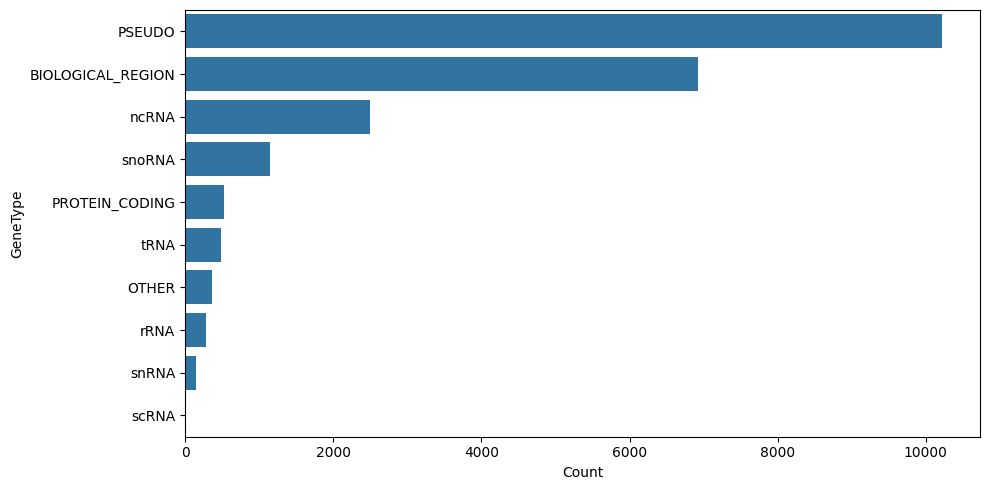

In [6]:
#plot the distribution of GeneType
plt.figure(figsize=(10,5))
sns.countplot(y='GeneType', data=train_df, order=train_df['GeneType'].value_counts().index)
plt.xlabel('Count')
plt.ylabel('GeneType')
plt.tight_layout()
plt.show()

From the plot, it is immediately apparent that the dataset is highly imbalanced. The distribution of samples across the different classes is extremely uneven, with the largest class containing nearly 10,000 samples, while the smallest class has only a single sample. This pronounced disparity highlights a significant challenge for any classification model, as the model may become biased toward the majority class and struggle to correctly predict the minority classes.

## Prediction

### Tokenization

In [7]:
#k-mer
def generate_kmers(sequence, k=6):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

def generate_kmers_batch(sequences, k=6):
    """
    sequences: list of strings, e.g. ["ATGCGT", "GGCTAAGT"]
    returns: list of lists of k-mers
    """
    return [generate_kmers(seq, k) for seq in sequences]

train_df['k-mer'] = generate_kmers_batch(train_df['NucleotideSequence'])
val_df['k-mer'] = generate_kmers_batch(val_df['NucleotideSequence'])
test_df['k-mer'] = generate_kmers_batch(test_df['NucleotideSequence'])

#dump on screen the example of k mer: start
train_df['k-mer'][0][:10]

['AGCTTA',
 'GCTTAG',
 'CTTAGC',
 'TTAGCA',
 'TAGCAC',
 'AGCACA',
 'GCACAG',
 'CACAGT',
 'ACAGTG',
 'CAGTGG']

### Label encoding

In [10]:
from itertools import product

#all possible k-mers for dna
k = 6
nucleotides = ['A','C','G','T']
all_kmers = [''.join(p) for p in product(nucleotides, repeat=k)]

#map k-mer to id (0 reserved for padding)
kmer2id = {kmer: idx+1 for idx, kmer in enumerate(all_kmers)}

def kmer_seq_to_ids(seq, kmer2id):
    return [kmer2id[k] for k in seq]

In [11]:
#convert to ID
X_train = [kmer_seq_to_ids(seq, kmer2id) for seq in train_df['k-mer']]
X_val = [kmer_seq_to_ids(seq, kmer2id) for seq in val_df['k-mer']]
X_test = [kmer_seq_to_ids(seq, kmer2id) for seq in test_df['k-mer']]

#dump on screen the example of ID: start
X_train[0][:10]

[637, 2547, 1994, 3877, 3218, 581, 2323, 1100, 303, 1211]

In [12]:
#initialize label encoder
le = LabelEncoder()

#fit and transform labels into numeric ids
le.fit(train_df['GeneType'])
y_train = le.transform(train_df['GeneType'])
y_val = le.transform(val_df['GeneType'])
y_test = le.transform(test_df['GeneType'])

### Padding

In [13]:
#maximum length of dna sequence
max_len = max_len = max(train_df['k-mer'].apply(len))

#pad sequences
X_train = pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')
X_val = pad_sequences(X_val, maxlen=max_len, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post', truncating='post')

### Transformer model

In [14]:
def build_kmer_transformer_model(vocab_size, max_len, embed_dim=64, num_heads=4, ff_dim=128, num_classes=2, dropout=0.1):
    inputs = layers.Input(shape=(max_len,), dtype='int32')

    #embedding layer with mask on padding (id=0)
    x = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)(inputs)

    #multi-head self-attention (mask handled automatically)
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    attn_output = layers.Dropout(dropout)(attn_output)
    x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)

    #feedforward network
    ffn = layers.Dense(ff_dim, activation='relu')(x)
    ffn_output = layers.Dense(embed_dim)(ffn)
    ffn_output = layers.Dropout(dropout)(ffn_output)
    x = layers.LayerNormalization(epsilon=1e-6)(x + ffn_output)

    #global average pooling
    x = layers.GlobalAveragePooling1D()(x)

    #final classification layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    #build model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

#example usage
vocab_size = 4097   #k-mer 6 + 1 for padding
num_classes = 103   #example number of classes

model = build_kmer_transformer_model(
    vocab_size=vocab_size,
    max_len=max_len,
    embed_dim=128,
    num_heads=4,
    ff_dim=256,
    num_classes=num_classes,
    dropout=0.1
)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 995)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 995, 128)  │    524,416 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 995, 128)  │    263,808 │ embedding[0][0],  │
│ (MultiHeadAttentio… │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 995, 128)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 995, 128)  │          0 │ embedding[0][0],  │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 995, 128)  │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 995, 256)  │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 995, 128)  │     32,896 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 995, 128)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 995, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 995, 128)  │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 103)       │     13,287 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 867,943 (3.31 MB)

 Trainable params: 867,943 (3.31 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
#early stopping
early_stop = EarlyStopping(
    monitor='val_loss',        #metric to monitor
    patience=5,                #stop if no improvement after 5 epochs
    restore_best_weights=True  #restore model weights from best epoch
)

#learning rate decay
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',        #metric to monitor
    factor=0.5,                #reduce lr by factor
    patience=3,                #wait 3 epochs before reducing
    min_lr=1e-6                #minimum learning rate
)



model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),  #provide validation set explicitly
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 104s 121ms/step - accuracy: 0.5894 - loss: 1.1821 - val_accuracy: 0.7527 - val_loss: 0.6773 - learning_rate: 0.0010
Epoch 2/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 80s 113ms/step - accuracy: 0.8080 - loss: 0.5872 - val_accuracy: 0.8536 - val_loss: 0.4654 - learning_rate: 0.0010
Epoch 3/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 80s 114ms/step - accuracy: 0.8630 - loss: 0.4430 - val_accuracy: 0.8589 - val_loss: 0.4157 - learning_rate: 0.0010
Epoch 4/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 80s 113ms/step - accuracy: 0.8759 - loss: 0.4015 - val_accuracy: 0.9139 - val_loss: 0.2892 - learning_rate: 0.0010
Epoch 5/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 80s 113ms/step - accuracy: 0.9066 - loss: 0.2988 - val_accuracy: 0.9141 - val_loss: 0.2517 - learning_rate: 0.0010
Epoch 6/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 80s 113ms/step - accuracy: 0.9193 - loss: 0.2543 - val_accuracy: 0.9259 - val_loss: 0.2100 - learning_rate: 0.0010
Epoch 7/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 80s 113ms/step - accur

In [16]:
_,accuracy = model.evaluate(X_train,y_train)
print('Train accuracy:',accuracy)
_,accuracy = model.evaluate(X_test,y_test)
print('Test accuracy:',accuracy)

707/707 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.9930 - loss: 0.0269
Train accuracy: 0.9929624199867249
261/261 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9560 - loss: 0.3431
Test accuracy: 0.9690127372741699


The test accuracy achieved by the model is 0.97, which is relatively high considering the number of classes (10) and the significant imbalance present in the dataset. Taking into account that some classes have only a few samples while others contain thousands, reaching this level of accuracy indicates that the transformer model is handling the data distribution effectively. It suggests that the model is able to capture meaningful patterns across both the majority and minority classes, despite the challenges posed by the uneven class frequencies. Overall, these results provide encouraging evidence that the transformer architecture is capable of learning robust representations even from datasets with highly skewed class distributions.

Furthermore, considering that the training accuracy reaches 0.99, there is minimal indication of overfitting in the model. This stability in performance is likely supported by the implementation of early stopping, which monitors the validation loss and halts training when no further improvement is observed. As a result, the model maintains a balanced generalization capability, avoiding excessive memorization of the training data while still capturing the relevant patterns necessary for accurate predictions.

261/261 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step


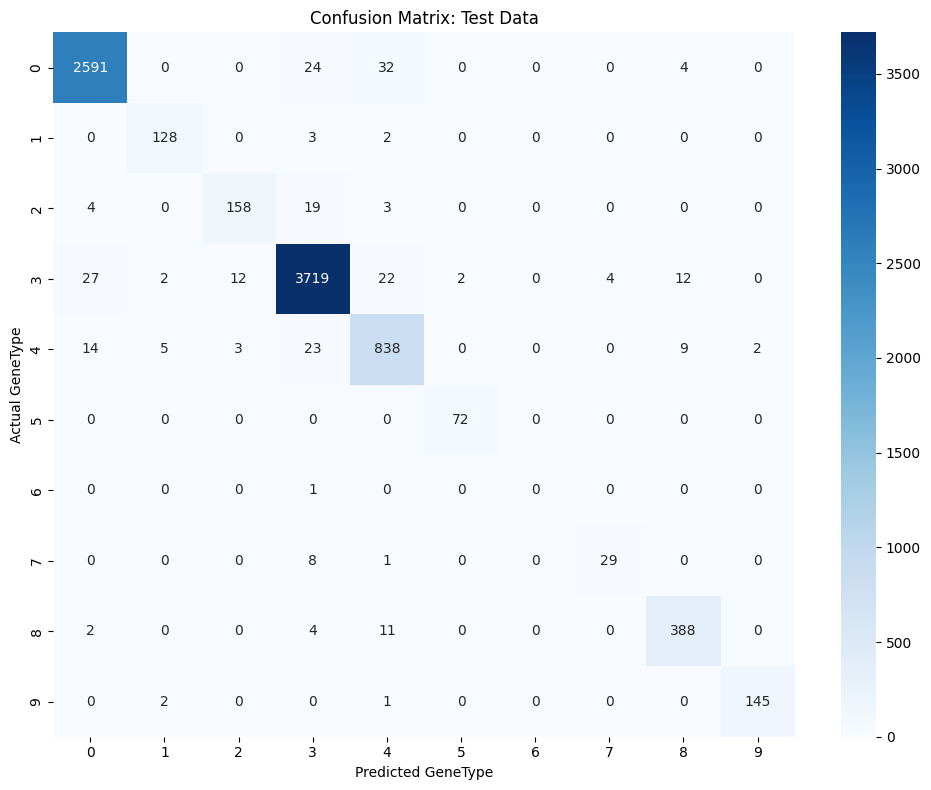

In [17]:
y_probs = model.predict(X_test)             #predict probabilities
y_pred = np.argmax(y_probs, axis=1)        #convert to class indices

#compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

#display confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Test Data')
plt.xlabel('Predicted GeneType')
plt.ylabel('Actual GeneType')
plt.tight_layout()
plt.show()
plt.show()

With the exception of the least represented classes (6), all other classes appear to be generally well classified, as evidenced by the confusion matrix. The model demonstrates strong discriminative ability for the majority of classes, with high true positive rates and minimal confusion across most categories. The limited performance on classes 6 and 7 is likely attributable to their underrepresentation in the training set, which reduces the model’s ability to learn robust patterns for these categories.